<a href="https://colab.research.google.com/github/Kallol7/tensorflowProjects/blob/main/Dog%20Breed%20Classification/dog_breed_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import json

In [2]:
data_folders =["test","train","valid"]

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/dog_breed.zip" -d "/content"

In [5]:
test_data_names = os.listdir("test")
train_data_names = os.listdir("train")
valid_data_names= os.listdir("valid")
assert test_data_names == train_data_names

# Look for class name mismatch
for v_name in valid_data_names:
    if v_name not in test_data_names:
        print(f"'{v_name}' need to be fixed")

'American  Spaniel' need to be fixed


In [6]:
class_map = {} # {class_name: index}
for indx,name in enumerate(sorted(train_data_names)):
    class_map[name] = indx
class_map

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [7]:
# to prevent class mismatch, only once
try:
  # current folder: "content"
  os.rename("./valid/American  Spaniel", "./valid/American Spaniel") # (source,destination)
  print("'American  Spaniel' folder in validation renamed to 'American Spaniel'")
except:
  print("Alredy renamed!")

'American  Spaniel' folder in validation renamed to 'American Spaniel'


In [8]:
# Final check for class name mismatch
valid_data_names= os.listdir("valid")
found = False
for v_name in valid_data_names:
    if v_name not in test_data_names:
        print(f"'{v_name}' need to be fixed")
        found = True
if not found:
    print("No more fix needed")

No more fix needed


In [9]:
def load_data(directory,class_names,batch_size,img_size):
    class_indx = [class_map[name] for name in class_names]
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode='int',
        class_names=list(class_map.keys()),
        color_mode="rgb",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42,
        crop_to_aspect_ratio=False
    )

def scale(x,y):
    return (x*1./255,y)

def augment_images(image, label):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ])

    return data_augmentation(image), label

def augment_and_add(train_data):
    combined_dataset = train_data
    for i in range(10):
        # Apply data augmentation to each image in the dataset
        augmented_data = train_data.map(augment_images)
        # Combine both datasets into one
        combined_dataset = tf.data.Dataset.concatenate(combined_dataset, augmented_data)
    return combined_dataset

In [10]:
batch_size = 8000 #10000
img_size = (32,32)

train_data = load_data('train',train_data_names,batch_size,img_size)
train_data = train_data.map(scale)

Found 7946 files belonging to 70 classes.


In [11]:
def draw_countplot(train_iter):
    all_y = []
    while True:
      batch = None
      try:
        batch = train_iter.next()
      except:
        break
      all_y.extend(batch[1])

    sns.set(style='whitegrid',rc={"figure.figsize": (20, 6)},font_scale=1)
    sns.countplot(x=all_y,dodge=True,width=.8,edgecolor="none",palette="rocket",order=pd.value_counts(all_y).index)
    plt.xlabel("Class")
    plt.show()

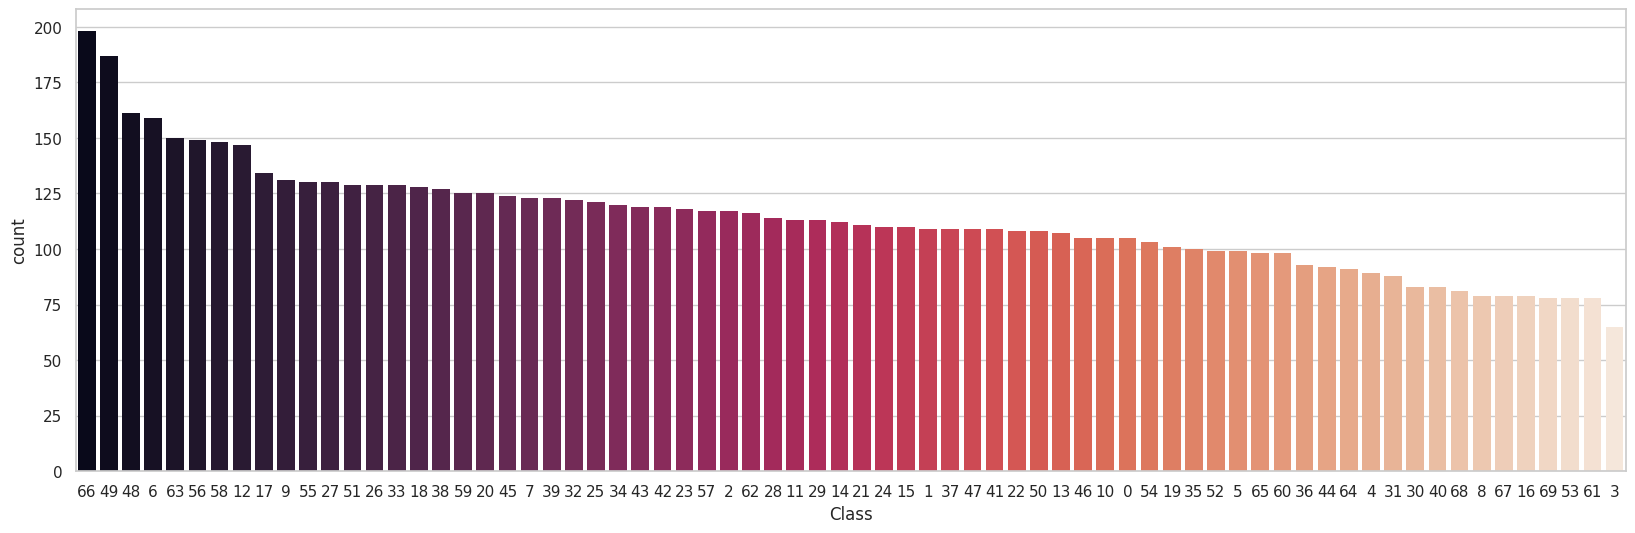

In [12]:
# Visualize Class Imbalance
train_iter= train_data.as_numpy_iterator()
draw_countplot(train_iter)
del train_iter

In [13]:
def apply_resampling(train_data):
    under = RandomUnderSampler(sampling_strategy="not minority")
    over = SMOTE(sampling_strategy="not majority")

    # Separate features and labels
    train_features = []
    train_labels = []
    for batch in train_data:
        train_features.append(batch[0])
        train_labels.append(batch[1])
    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)

    # Reshape the features for resampling
    train_features = np.reshape(train_features, (train_features.shape[0], -1))

    # Apply oversampling first
    train_features, train_labels = over.fit_resample(train_features, train_labels)

    # Apply undersampling
    train_features, train_labels = under.fit_resample(train_features, train_labels)

    # Reshape the features back to the original shape
    train_features = np.reshape(train_features, (train_features.shape[0], *img_size, 3))

    # Create a TensorFlow dataset from the resampled data
    final_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    final_dataset = final_dataset.shuffle(train_features.shape[0]).batch(batch_size)

    num_train_examples = train_features.shape[0]
    return final_dataset, num_train_examples

def smote_and_undersample(train_data):
    final_dataset, num_train_examples = apply_resampling(train_data)

    assert isinstance(final_dataset, tf.data.Dataset)  # Ensure final_dataset is of type tf.data.Dataset
    return final_dataset, num_train_examples

In [14]:
train_data,num_train_examples = smote_and_undersample(train_data)
print("After resampling ", num_train_examples, "total images")

After resampling  13860 total images


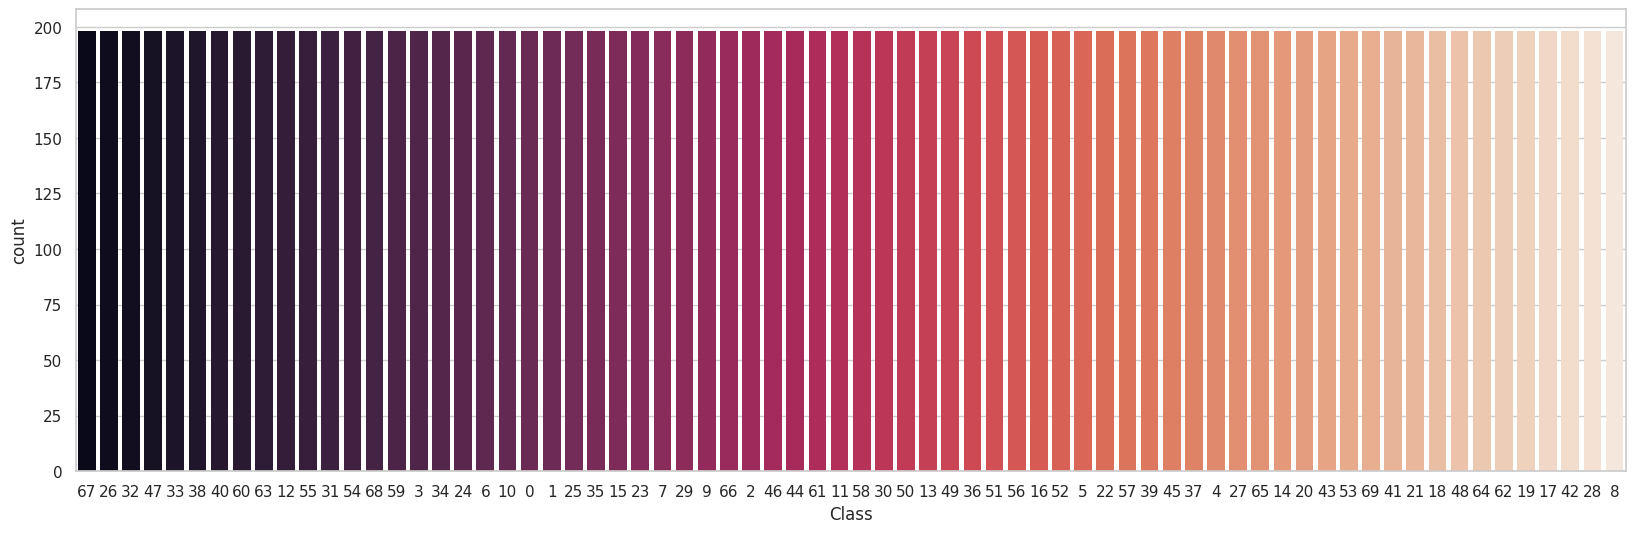

In [15]:
# Class distribution after balancing
train_iter= train_data.as_numpy_iterator()
draw_countplot(train_iter)
del train_iter

In [16]:
train_data = augment_and_add(train_data)

test_data = load_data('test', test_data_names,batch_size,img_size)
test_data = test_data.map(scale)

valid_data = load_data('valid', valid_data_names,batch_size,img_size)
valid_data = valid_data.map(scale)

Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [17]:
# 10 augemted images + the original image = 11, hence num_train_examples*11
num_train_examples = num_train_examples*11
train_data = train_data.cache().repeat().shuffle(num_train_examples) # .batch(batch_size) already applied
valid_data = valid_data.cache() # .batch(batch_size) already applied
test_batch = test_data.repeat().as_numpy_iterator()

In [20]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=300,
    mode="max",
    restore_best_weights=True
)

# For learning rate decay
def lr_scheduler(epoch, lr):
    if epoch%80==0:
      return lr * tf.math.exp(-0.1)
    else:
      return lr
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [21]:
# checkpoint path
save_path = "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints/"

# callback to save each epoch
save_last_epoch = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path+"last_epoch.h5",
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# get the best validation accuracy from previous model fit
best_val_accuracy = float('-inf')
with open(save_path+"best_val_accuracy.json","r") as f:
    best_val_accuracy = max(best_val_accuracy,json.load(f))

# callback to save best model
class SaveBestModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        current_val_accuracy = logs.get('val_accuracy')
        global best_val_accuracy
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy  # update
            self.model.save(save_path+"best_model.h5")  # update by overwriting
            with open(save_path+"best_val_accuracy.json","w") as f:
                json.dump(best_val_accuracy,f)  # update by overwriting

In [18]:
def create_model(learning_rate=1e-3):
    # Use dropout on hidden layers when there are
    # lots of parameters and has a chance of overfitting.
    # Good droupout range 0.5 to 0.8
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding="same",activation=tf.nn.relu,input_shape=(*img_size,3)),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(16,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(16,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(12,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=75,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.72),
        tf.keras.layers.Dense(units=70)
    ])

    # Using softmax and SparseCategoricalCrossentropy can have issues.
    # Safter approach, use linear output(no activation on output layer) and
    # use SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer= tf.optimizers.Adam(learning_rate),
        loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

In [23]:
"""
Whenever model structure is changed,
put "-Infinity" (without quotes)
inside best_val_accuracy.json file.
Otherwise code will fit the same old model.
"""
# Load the last saved model from checkpoint or use the new model
model = None
if best_val_accuracy > float('-inf'):
    model = tf.keras.models.load_model(save_path+"last_epoch.h5")
else:
    model = create_model(1e-3)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        2

In [22]:
#  validation_steps: Only relevant if `validation_data` is provided and
#                 is a `tf.data` dataset. Total number of steps (batches of
#                 samples) to draw before stopping when performing validation
#                 at the end of every epoch. If 'validation_steps' is None,
#                 validation will run until the `validation_data` dataset is
#                 exhausted. In the case of an infinitely repeated dataset, it
#                 will run into an infinite loop. If 'validation_steps' is
#                 specified and only part of the dataset will be consumed, the
#                 evaluation will start from the beginning of the dataset at each
#                 epoch. This ensures that the same validation samples are used
#                 every time.

In [ ]:
steps_per_epoch = tf.math.ceil(num_train_examples/batch_size)
validation_steps = tf.math.ceil(700/batch_size)

history = model.fit(
    train_data,epochs=15000,
    validation_data=valid_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, lr_decay,save_last_epoch, SaveBestModel()]
)

Epoch 1/15000
20/20 [==============================] - ETA: 0s - loss: 4.2423 - accuracy: 0.0186  
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints/last_epoch.h5
20/20 [==============================] - 2615s 130s/step - loss: 4.2423 - accuracy: 0.0186 - val_loss: 4.2134 - val_accuracy: 0.0357 - lr: 9.0484e-04
Epoch 2/15000


In [ ]:
# #  Remove files from previous checkpoint
# #  !!! Careful !!!
# for file in os.listdir(save_path):
#     os.remove(os.path.join(save_path,file))

In [ ]:
#  Save the final model
model.save(save_path+"final_model.h5")

In [ ]:
batch= test_batch.next()
batch = batch[:16]
res = model.predict(batch[0])

fig,axes = plt.subplots(2,8,figsize=(12,5))
plt.rcParams.update({'font.size': 6})
for i,ax in enumerate(axes.flatten()):
    true_label = res[i].argmax()
    predicted = batch[1][i]
    ax.imshow(batch[0][i])
    ax.set_title(f"Breed: \n{test_data_names[true_label]}")
    ax.set_xlabel(f"Predicted:\n{test_data_names[predicted]}")

fig.tight_layout(h_pad=2,w_pad=3)
plt.show()

In [ ]:
model.evaluate(test_data)